# Versicherungsbetrug erkennen: Ein maschinelles Lernmodell zur Feststellung von Anomalien
<div style="text-align: center;">
    <img src="markup_title_picture.png" alt="Projektbild" width="600">
</div>

### Dieses Projekt zielt darauf ab, ein intelligentes Modell zur Erkennung von Versicherungsbetrug zu entwickeln. Anhand historischer Schadensmeldungen, die bereits als betrügerisch oder legitim gekennzeichnet sind, wird ein System geschaffen, das in der Lage ist, verdächtige Muster automatisch zu identifizieren und so die Betrugserkennung effizient zu optimieren.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import joblib

In [46]:
df = pd.read_csv('damage_reports_DE.csv')
df.head()

,Kunden_ID,Versicherungsabschluss,Schadens_ID,Versicherungsart,Schadensmeldung,Schadensbetrag,Vorherige_Schaeden,Schadensort,BeteiligtePersonen,Betrug
0,K0393,2021-10-09,S00393,Kfz,2022-08-01,648,1,München,2,False
1,K0718,2021-10-10,S00718,Kfz,2023-10-04,4399,2,Leipzig,1,False
2,K0204,2023-04-01,S00204,Hausrat,2023-08-24,2688,0,Nürnberg,1,False
3,K0405,2021-04-21,S00405,Haftpflichtversicherung,2023-04-11,1250,1,Düsseldorf,1,False
4,K0038,2022-09-12,S00038,Kfz,2023-11-27,1669,2,Hamburg,1,False


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Kunden_ID               1000 non-null   object
 1   Versicherungsabschluss  1000 non-null   object
 2   Schadens_ID             1000 non-null   object
 3   Versicherungsart        1000 non-null   object
 4   Schadensmeldung         1000 non-null   object
 5   Schadensbetrag          1000 non-null   int64 
 6   Vorherige_Schaeden      1000 non-null   int64 
 7   Schadensort             1000 non-null   object
 8   BeteiligtePersonen      1000 non-null   int64 
 9   Betrug                  1000 non-null   bool  
dtypes: bool(1), int64(3), object(6)
memory usage: 71.4+ KB


## Datenbereinigung

In [6]:
df["Versicherungsabschluss"] = pd.to_datetime(df["Versicherungsabschluss"])

In [7]:
df["Schadensmeldung"] = pd.to_datetime(df["Schadensmeldung"])

## Visualisierungen

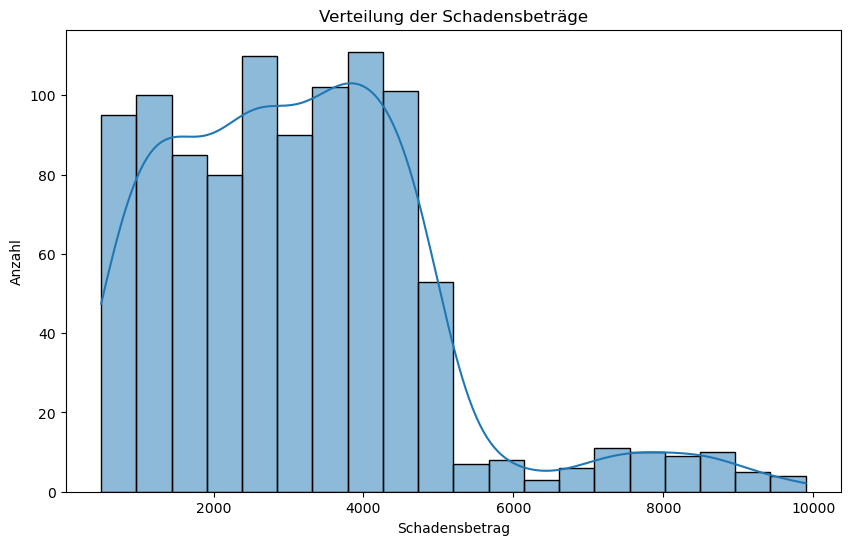

In [9]:
# Histogramm der Schadensbeträge
plt.figure(figsize=(10, 6))
sns.histplot(df["Schadensbetrag"], kde=True)
plt.title("Verteilung der Schadensbeträge")
plt.xlabel("Schadensbetrag")
plt.ylabel("Anzahl")
plt.show()

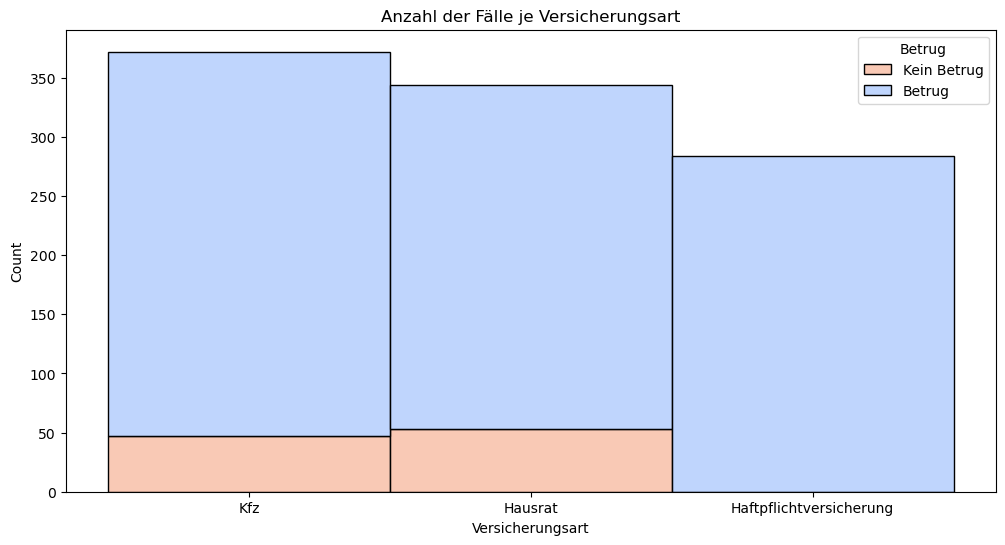

In [10]:
# Countplot der Versicherungsarten, gestapelt nach Betrug und kein Betrug
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x="Versicherungsart", hue="Betrug", multiple="stack", palette="coolwarm")
plt.title("Anzahl der Fälle je Versicherungsart")
plt.legend(title="Betrug", labels=["Kein Betrug", "Betrug"])
plt.show()

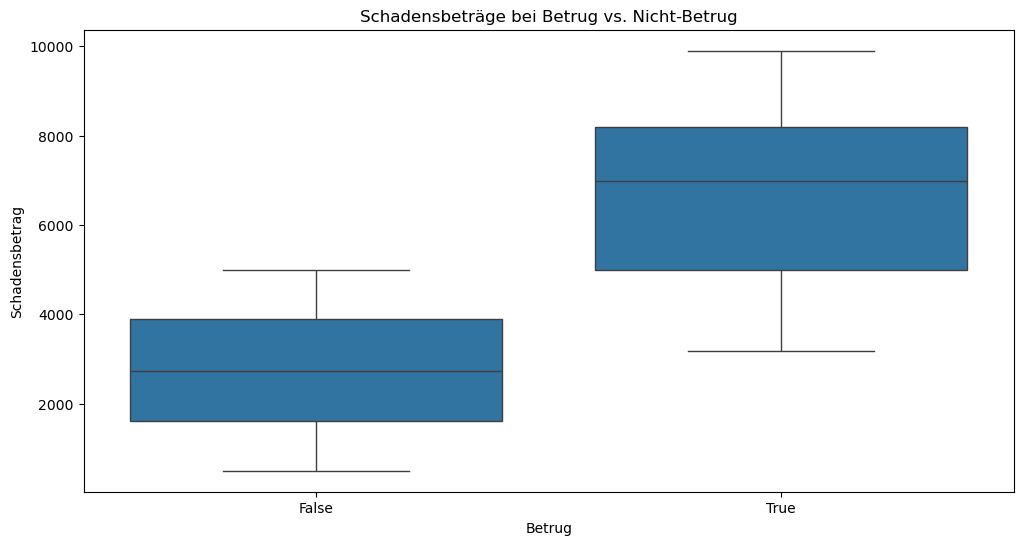

In [11]:
# Boxplot zur Untersuchung der Schadensbeträge zwischen Betrug und Nicht-Betrug
plt.figure(figsize=(12, 6))
sns.boxplot(x="Betrug", y="Schadensbetrag", data=df)
plt.title("Schadensbeträge bei Betrug vs. Nicht-Betrug")
plt.xlabel("Betrug")
plt.ylabel("Schadensbetrag")
plt.show()

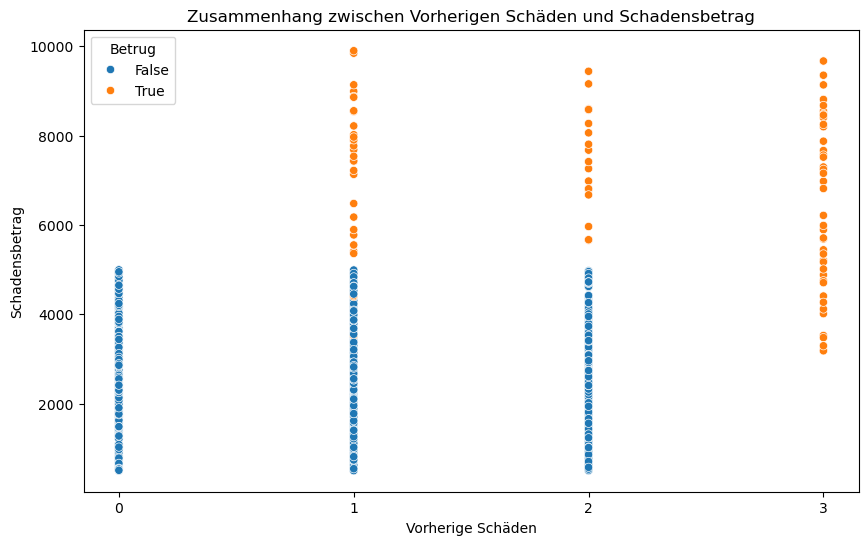

In [12]:
# Scatterplot zur Visualisierung der Beziehung zwischen Vorherige Schäden und Schadensbetrag
plt.figure(figsize=(10, 6))
sns.scatterplot(x="Vorherige_Schaeden", y="Schadensbetrag", hue="Betrug", data=df)
plt.title("Zusammenhang zwischen Vorherigen Schäden und Schadensbetrag")
plt.xticks(ticks=range(df["Vorherige_Schaeden"].min(), df["Vorherige_Schaeden"].max() + 1))
plt.xlabel("Vorherige Schäden")
plt.ylabel("Schadensbetrag")
plt.show()

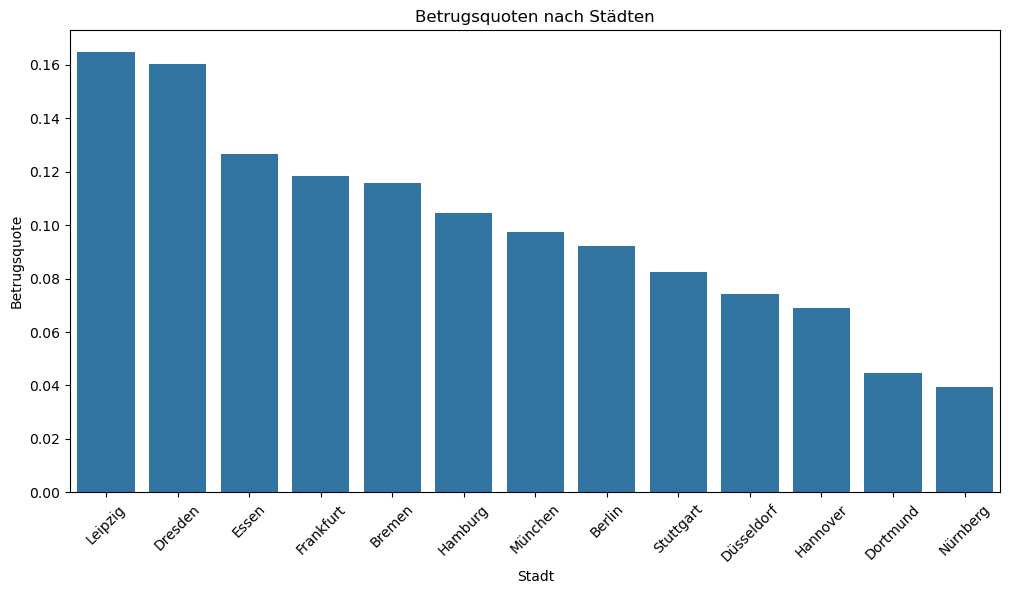

In [13]:
# Visualisierung der Betrugsquoten nach Städten
betrug_staedte = df.groupby("Schadensort")["Betrug"].mean().reset_index()
betrug_staedte.columns = ["Stadt", "Betrugsquote"]
betrug_staedte = betrug_staedte.sort_values(by="Betrugsquote", ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(x="Stadt", y="Betrugsquote", data=betrug_staedte)
plt.title("Betrugsquoten nach Städten")
plt.xticks(rotation=45)
plt.show()

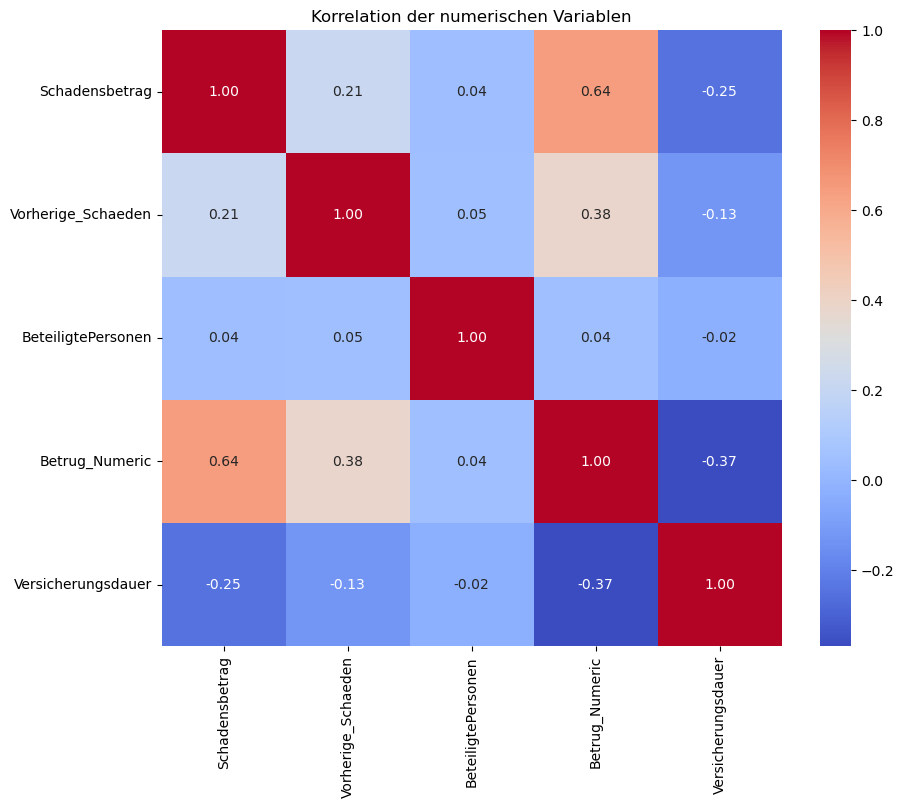

In [14]:
# Numerische Anpassung der Spalten
df["Betrug_Numeric"] = df["Betrug"].astype(int)
df["Versicherungsdauer"] = (df["Schadensmeldung"] - df["Versicherungsabschluss"]).dt.days
# Heatmap der numerischen Korrelationen
numerical_df = df.select_dtypes(include=['number'])
plt.figure(figsize=(10, 8))
sns.heatmap(numerical_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Korrelation der numerischen Variablen")
plt.show()

## Vorbereitung der Modellierung

In [16]:
df.head()

,Kunden_ID,Versicherungsabschluss,Schadens_ID,Versicherungsart,Schadensmeldung,Schadensbetrag,Vorherige_Schaeden,Schadensort,BeteiligtePersonen,Betrug,Betrug_Numeric,Versicherungsdauer
0,K0393,2021-10-09,S00393,Kfz,2022-08-01,648,1,München,2,False,0,296
1,K0718,2021-10-10,S00718,Kfz,2023-10-04,4399,2,Leipzig,1,False,0,724
2,K0204,2023-04-01,S00204,Hausrat,2023-08-24,2688,0,Nürnberg,1,False,0,145
3,K0405,2021-04-21,S00405,Haftpflichtversicherung,2023-04-11,1250,1,Düsseldorf,1,False,0,720
4,K0038,2022-09-12,S00038,Kfz,2023-11-27,1669,2,Hamburg,1,False,0,441


In [17]:
# One-Hot-Encoding für den Schadensort und die Versicherungsart
df = pd.get_dummies(df, columns=["Schadensort", "Versicherungsart"])
df

,Kunden_ID,Versicherungsabschluss,Schadens_ID,Schadensmeldung,Schadensbetrag,Vorherige_Schaeden,BeteiligtePersonen,Betrug,Betrug_Numeric,Versicherungsdauer,...,Schadensort_Frankfurt,Schadensort_Hamburg,Schadensort_Hannover,Schadensort_Leipzig,Schadensort_München,Schadensort_Nürnberg,Schadensort_Stuttgart,Versicherungsart_Haftpflichtversicherung,Versicherungsart_Hausrat,Versicherungsart_Kfz
0,K0393,2021-10-09,S00393,2022-08-01,648,1,2,False,0,296,...,False,False,False,False,True,False,False,False,False,True
1,K0718,2021-10-10,S00718,2023-10-04,4399,2,1,False,0,724,...,False,False,False,True,False,False,False,False,False,True
2,K0204,2023-04-01,S00204,2023-08-24,2688,0,1,False,0,145,...,False,False,False,False,False,True,False,False,True,False
3,K0405,2021-04-21,S00405,2023-04-11,1250,1,1,False,0,720,...,False,False,False,False,False,False,False,True,False,False
4,K0038,2022-09-12,S00038,2023-11-27,1669,2,1,False,0,441,...,False,True,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,K0347,2022-10-01,S00347,2023-07-23,4453,1,2,False,0,295,...,False,False,False,False,False,False,False,False,True,False
996,K0777,2022-01-30,S00777,2022-10-05,816,1,3,False,0,248,...,False,False,False,False,False,False,False,False,False,True
997,K0338,2022-10-24,S00338,2023-10-27,1779,1,1,False,0,368,...,False,False,False,False,False,False,False,False,False,True
998,K0386,2023-01-14,S00386,2023-03-29,4725,2,1,False,0,74,...,False,False,False,False,False,True,False,True,False,False


In [18]:
# Konvertiere die Datumsangaben in numerische Werte (Tage seit einem Stichtag)
df["Versicherungsabschluss_Tage"] = (df["Versicherungsabschluss"] - pd.to_datetime("2020-01-01")).dt.days
df["Schadenmeldung_Tage"] = (df["Schadensmeldung"] - pd.to_datetime("2020-01-01")).dt.days

# Entferne die originalen Datumsangaben aus den Features
x = df.drop(columns=["Betrug", "Betrug_Numeric", "Kunden_ID", "Schadens_ID", "Versicherungsabschluss", "Schadensmeldung"])  # Entferne Datumsangaben und andere nicht relevante Spalten
y = df["Betrug"]

# Aufteilen der Daten in Trainings- und Testsets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

## Training und Test des Modells

In [20]:
# Modelltraining
model = DecisionTreeClassifier(random_state=42)
model.fit(x_train, y_train)

DecisionTreeClassifier(random_state=42)

In [21]:
# Vorhersage auf dem Testdatensatz
y_pred = model.predict(x_test)

# Bewertung des Modells
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.98
Confusion Matrix:
 [[265   4]
 [  2  29]]
Classification Report:
               precision    recall  f1-score   support

       False       0.99      0.99      0.99       269
        True       0.88      0.94      0.91        31

    accuracy                           0.98       300
   macro avg       0.94      0.96      0.95       300
weighted avg       0.98      0.98      0.98       300



## Analyse und Abspeichern des Modells

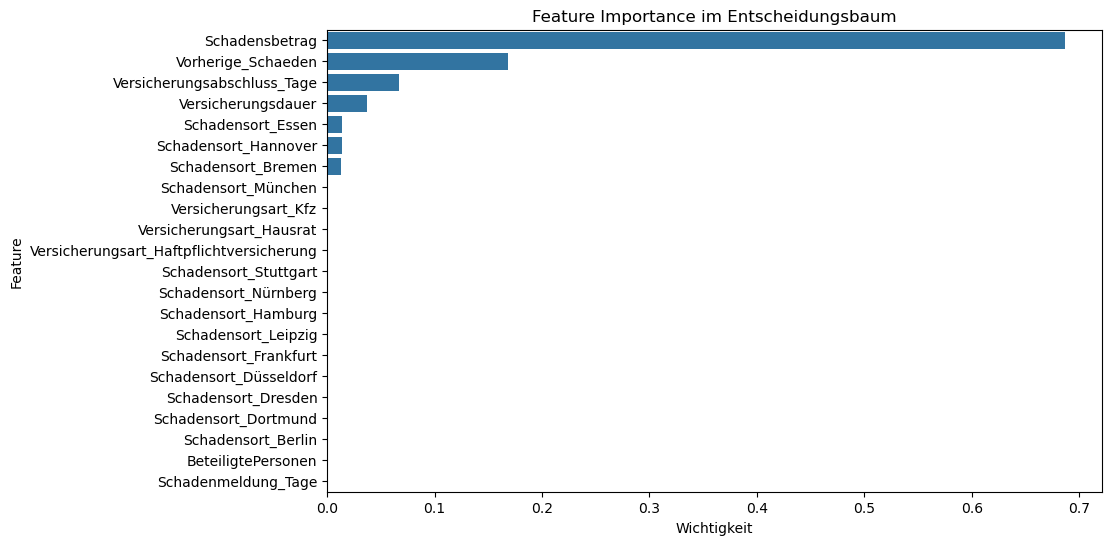

In [43]:
# Analyse der wichtigsten Features
importances = model.feature_importances_
feature_names = x.columns
feature_importance_df = pd.DataFrame({"Feature": feature_names, "Importance": importances})
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

# Visualisierung der Feature-Wichtigkeit
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=feature_importance_df)
plt.title("Feature Importance im Entscheidungsbaum")
plt.xlabel("Wichtigkeit")
plt.show()

In [24]:
# Speichern des trainierten Modells
joblib.dump(model, 'decision_tree_model.pkl')

['decision_tree_model.pkl']